# Comparing different electricity contracts

In [2]:
import pandas as pd
import os

## Load SPOT-price historical data (single file per day from Vattenfall spot price history)
[Link to Vattenfall page that has spot prices](https://www.vattenfall.fi/sahkosopimukset/porssisahko/tuntispot-hinnat-sahkoporssissa/)

In [3]:
spot_prices = []
for file in os.listdir(os.getcwd() + '/data'):
    if file.startswith('data'):
        spot_prices.append('data/' + file)

In [4]:
df = pd.DataFrame()
for day_file in spot_prices:
    data = pd.read_excel(day_file, 'WorkSheet', header=None, skiprows=1, names=['measured_at','spot_price'])
    df = pd.concat([df, data])
# No timezone specified,already in local time
df['measured_at'] = pd.to_datetime(df['measured_at'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('Europe/Helsinki')
df['spot_price'] = df['spot_price'] / 100
df

,measured_at,spot_price
0,2022-11-01 00:00:00+02:00,0.1464
1,2022-11-01 01:00:00+02:00,0.1117
2,2022-11-01 02:00:00+02:00,0.1158
3,2022-11-01 03:00:00+02:00,0.1158
4,2022-11-01 04:00:00+02:00,0.1158
...,...,...
19,2022-11-09 19:00:00+02:00,0.2521
20,2022-11-09 20:00:00+02:00,0.2042
21,2022-11-09 21:00:00+02:00,0.2205
22,2022-11-09 22:00:00+02:00,0.2098


In [6]:
print('First measurement:', min(df['measured_at']))
print('Last measurement:', max(df['measured_at']))

First measurement: 2022-11-01 00:00:00+02:00
Last measurement: 2022-11-30 23:00:00+02:00


## Load personal consumption data (through Fingrid Datahub)

In [15]:
consumption_df = pd.read_csv('data/fingrid_marraskuu.csv', sep=';', decimal=',')
consumption_df = consumption_df[['Alkuaika', 'Määrä']]
consumption_df['Alkuaika'] = pd.to_datetime(consumption_df['Alkuaika'], format='%Y-%m-%dT%H:%M:%SZ').dt.tz_localize('utc').dt.tz_convert('Europe/Helsinki')
consumption_df = consumption_df.rename(columns = {'Alkuaika' : 'measured_at', 'Määrä' : 'consumption'})
consumption_df

,measured_at,consumption
0,2022-11-01 00:00:00+02:00,0.91
1,2022-11-01 01:00:00+02:00,1.40
2,2022-11-01 02:00:00+02:00,0.23
3,2022-11-01 03:00:00+02:00,0.81
4,2022-11-01 04:00:00+02:00,0.77
...,...,...
715,2022-11-30 19:00:00+02:00,0.77
716,2022-11-30 20:00:00+02:00,0.77
717,2022-11-30 21:00:00+02:00,0.78
718,2022-11-30 22:00:00+02:00,4.33


## Merge files together

In [16]:
total_df = pd.merge(df, consumption_df, on=['measured_at'])
total_df

,measured_at,spot_price,consumption
0,2022-11-01 00:00:00+02:00,0.1464,0.91
1,2022-11-01 01:00:00+02:00,0.1117,1.40
2,2022-11-01 02:00:00+02:00,0.1158,0.23
3,2022-11-01 03:00:00+02:00,0.1158,0.81
4,2022-11-01 04:00:00+02:00,0.1158,0.77
...,...,...,...
715,2022-11-09 19:00:00+02:00,0.2521,0.81
716,2022-11-09 20:00:00+02:00,0.2042,0.84
717,2022-11-09 21:00:00+02:00,0.2205,1.12
718,2022-11-09 22:00:00+02:00,0.2098,2.85


## Calculate costs for fixed price contract (Fortum 24 kk takuu price) and spot price contract

In [17]:
FIXED_PRICE = 0.2657
SPOT_PRICE = 0.0027

total_df['fixed_price_cost'] = total_df['consumption'] * FIXED_PRICE
total_df['spot_price_cost'] = total_df['consumption'] * (total_df['spot_price'] + SPOT_PRICE)
total_df.sort_values('measured_at', inplace=True)
total_df

,measured_at,spot_price,consumption,fixed_price_cost,spot_price_cost
0,2022-11-01 00:00:00+02:00,0.1464,0.91,0.241787,0.135681
1,2022-11-01 01:00:00+02:00,0.1117,1.40,0.371980,0.160160
2,2022-11-01 02:00:00+02:00,0.1158,0.23,0.061111,0.027255
3,2022-11-01 03:00:00+02:00,0.1158,0.81,0.215217,0.095985
4,2022-11-01 04:00:00+02:00,0.1158,0.77,0.204589,0.091245
...,...,...,...,...,...
571,2022-11-30 19:00:00+02:00,0.6182,0.77,0.204589,0.478093
572,2022-11-30 20:00:00+02:00,0.5809,0.77,0.204589,0.449372
573,2022-11-30 21:00:00+02:00,0.5174,0.78,0.207246,0.405678
574,2022-11-30 22:00:00+02:00,0.4310,4.33,1.150481,1.877921


# Calculating DUO contract price:
[Contract details here](https://www.fortum.fi/kotiasiakkaille/sahkoa-kotiin/sahkosopimukset/sopimusehdot?vtab=accordion-item-104412)
> Kulutusvaikutus lasketaan seuraavasti: summataan yhteen laskentajakson jokaisen tunnin kulutus kerrottuna kunkin tunnin pörssihinnalla. Kyseinen tulo jaetaan laskentajakson kokonaiskulutuksella, mistä syntyy asiakkaan laskutuskuukauden kulutuksella painotettu pörssihinta. Tästä vähennetään sähköpörssin laskutuskuukauden keskihinta. Syntynyt erotus kuvaa, kuinka hyvin asiakkaan kulutus painottuu edullisille pörssitunneille. Luvun ollessa etumerkiltään negatiivinen kulutusvaikutus laskee asiakkaan sähköenergian hintaa ja luvun ollessa etumerkiltään positiivinen kulutusvaikutus nostaa asiakkaan sähköenergian hintaa. Sähköenergian laskutushinta ei voi kuitenkaan olla negatiivinen. Laskentaperiaatteen matemaattinen kaava on siten seuraava:

In [35]:
SPOT_AVG_PRICE = total_df['spot_price_cost'].mean()
TOTAL_CONSUMPTION = total_df['consumption'].sum()
DUO_PRICE = 0.2499

print('Keskimääräinen spottihinta:', round(SPOT_AVG_PRICE,3), '€/kWh')
print('Kulutuksella painotettu pörssihinta:', round(total_df['spot_price_cost'].sum() / TOTAL_CONSUMPTION, 3), '€/kWh') 

duo_difference = (total_df['spot_price_cost'].sum() / TOTAL_CONSUMPTION) - SPOT_AVG_PRICE

Keskimääräinen spottihinta: 0.369 €/kWh
Kulutuksella painotettu pörssihinta: 0.272 €/kWh


In [19]:
print('Monthly cost for fixed price (', FIXED_PRICE, ' €/kWh):', str(round(total_df['fixed_price_cost'].sum(),2)), '€')
print('Monthly cost for spot price (spot price +', SPOT_PRICE, '€/kWh):', str(round(total_df['spot_price_cost'].sum(),2)), '€')
print('Monthly cost for DUO price:', str(round(TOTAL_CONSUMPTION * (DUO_PRICE + duo_difference),2)), '€')

Monthly cost for fixed price ( 0.2657  €/kWh): 259.36 €
Monthly cost for spot price (spot price + 0.0027 €/kWh): 265.92 €
Monthly cost for DUO price: 149.33 €


### So based on the results it looks like we have accidentally used electricity when it has been cheap and vice versa

In [24]:
import matplotlib.pyplot as plt

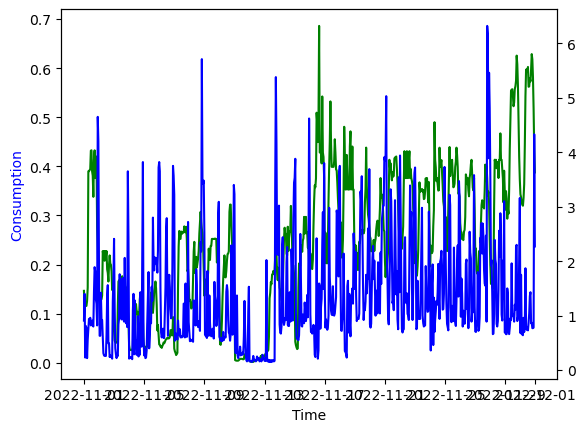

In [26]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(total_df['measured_at'], total_df['spot_price'],'g-')
ax2.plot(total_df['measured_at'], total_df['consumption'], 'b-')

ax1.set_xlabel('Time')
ax1.set_ylabel('Spot price', color='g')
ax1.set_ylabel('Consumption', color='b')

plt.show()